In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch import tensor
import numpy as np
import torchvision
from torchvision import datasets,transforms,models
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import shutil
!pip install torchmetrics
import torchmetrics
!pip install patool
import patoolib
import pathlib
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score

In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [46]:
mean = np.array([0.485,0.456,0.406])
std = np.array([0.229,0.224,0.225])

data_transforms = {
    'train':transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ]),
    'val':transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ])
}

In [47]:
if not os.path.exists('./TL_dataset'):
    patoolib.extract_archive('TL_dataset.zip')

In [48]:
# Extracting the dataset and creating the train and test folders
data_dir = pathlib.Path('TL_dataset')
classes = os.listdir(data_dir)
print('classes: ',classes)

# Creating the train and validation folders
if not os.path.exists('./splited_dataset'):
    os.makedirs('./splited_dataset/train')
    os.makedirs('./splited_dataset/val')

    # Creating the class folders in train and validation folders
    for i in classes:
        os.makedirs('./splited_dataset/train/' + i)
        os.makedirs('./splited_dataset/val/' + i)

random.seed(0)
# Splitting the dataset into train and test sets
for i in classes:
    src = "./TL_dataset/" + i # Folder to copy images from
    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, val_FileNames = np.split(np.array(allFileNames),
                                                              [int(len(allFileNames)*0.8)])
    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
    print('Total images: ', len(allFileNames))
    print('Training: ', len(train_FileNames))
    print('Validation: ', len(val_FileNames))
    # Copy-pasting images
    for name in train_FileNames:
        shutil.copy(name, "./splited_dataset/train/" + i)
    for name in val_FileNames:
        shutil.copy(name, "./splited_dataset/val/" + i)

classes:  ['1', '2', '3']
Total images:  42
Training:  33
Validation:  9
Total images:  42
Training:  33
Validation:  9
Total images:  42
Training:  33
Validation:  9


In [49]:
data_dir = 'splited_dataset'
sets = ['train','val']
image_datasets = {x:datasets.ImageFolder(os.path.join(data_dir,x),
                                         data_transforms[x])
                  for x in ['train','val']}
dataloaders = {x:torch.utils.data.DataLoader(image_datasets[x],batch_size=4,
                                             shuffle=True,num_workers=0)
                for x in ['train','val']}


In [50]:
dataset_sizes = {x:len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes
print(class_names)

['1', '2', '3']


In [51]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=15):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # create a list to store the training and validation accuracy values
    train_acc_list = []
    val_acc_list = []

    # create a list to store the training and validation loss values
    train_loss_list = []
    val_loss_list = []

    # initialize metric
    metric = torchmetrics.classification.Accuracy(task="multiclass", num_classes=3)
    predicted_labels = []
    ground_truth_labels = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-'*10)

        #Training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            #Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                #forward
                #track history only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _,preds = torch.max(outputs,1)
                    loss = criterion(outputs,labels)

                    #backward + optimize only in train
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                #statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_acc_list.append(epoch_acc.item())
                train_loss_list.append(epoch_loss)
            elif phase == 'val':
                val_acc_list.append(epoch_acc.item())
                val_loss_list.append(epoch_loss)

            predicted_labels.append(preds.cpu())
            ground_truth_labels.append(labels.cpu())


            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            #deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()


    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    #calculate accuracy
    predicted_labels = torch.cat(predicted_labels)
    ground_truth_labels = torch.cat(ground_truth_labels)
    accuracy = Accuracy(task="multiclass", num_classes=3)
    accuracy(predicted_labels, ground_truth_labels)
    print(f'Accuracy: {accuracy.compute():.4f}')

    #calculate precision
    precision = Precision(task="multiclass", average='macro', num_classes=3)
    precision(predicted_labels, ground_truth_labels)
    print(f'Precision: {precision.compute():.4f}')

    #calculate recall
    recall = Recall(task="multiclass", average='macro', num_classes=3)
    recall(predicted_labels, ground_truth_labels)
    print(f'Recall: {recall.compute():.4f}')

    #calculate f1 score
    f1 = F1Score(task="multiclass", average='macro', num_classes=3)
    f1(predicted_labels, ground_truth_labels)
    print(f'F1: {f1.compute():.4f}')

    #calculate confusion matrix
    cm = torchmetrics.functional.confusion_matrix(predicted_labels, ground_truth_labels, num_classes=3, task="multiclass")
    print(f'Confusion Matrix: \n{cm}')

    #plot the training and validation accuracy
    plt.figure(figsize=(10, 6))

    plt.plot(train_acc_list, label='Training Accuracy')
    plt.plot(val_acc_list, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.show()

    #plot the training and validation loss

    plt.figure(figsize=(10, 6))

    plt.plot(train_loss_list, label='Training Loss')
    plt.plot(val_loss_list, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    plt.show()

    #load best model weights
    model.load_state_dict(best_model_wts)
    return model

Epoch 0/24
----------
train Loss: 1.0847 Acc: 0.4444
val Loss: 0.7541 Acc: 0.7640

Epoch 1/24
----------
train Loss: 0.8614 Acc: 0.6349
val Loss: 0.5302 Acc: 0.9213

Epoch 2/24
----------
train Loss: 0.7492 Acc: 0.7063
val Loss: 0.3770 Acc: 0.9888

Epoch 3/24
----------
train Loss: 0.5710 Acc: 0.8492
val Loss: 0.2633 Acc: 1.0000

Epoch 4/24
----------
train Loss: 0.5833 Acc: 0.7937
val Loss: 0.2143 Acc: 0.9888

Epoch 5/24
----------
train Loss: 0.5606 Acc: 0.8016
val Loss: 0.1572 Acc: 1.0000

Epoch 6/24
----------
train Loss: 0.5233 Acc: 0.8254
val Loss: 0.1221 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.4781 Acc: 0.8333
val Loss: 0.1291 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.4303 Acc: 0.8889
val Loss: 0.1246 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.3849 Acc: 0.8968
val Loss: 0.1248 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.4823 Acc: 0.8651
val Loss: 0.1257 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.5138 Acc: 0.8095
val Loss: 0.1221 Acc: 1.0000

Ep

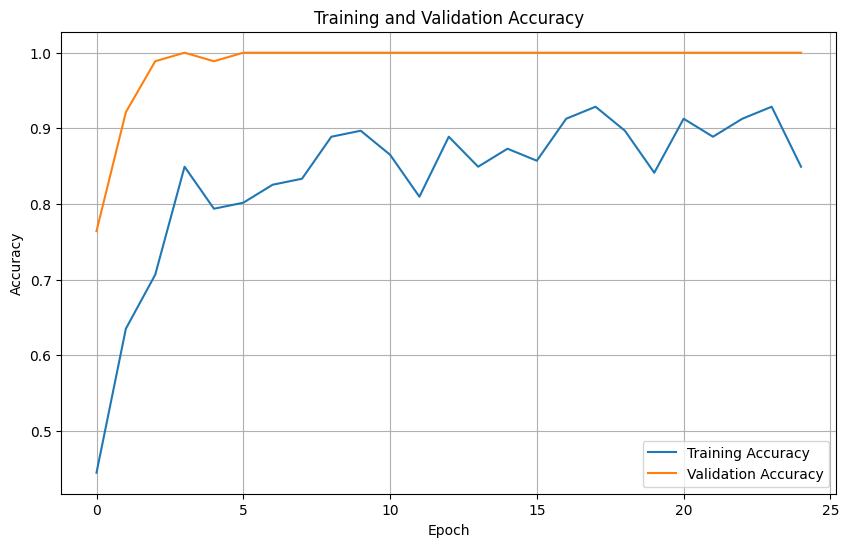

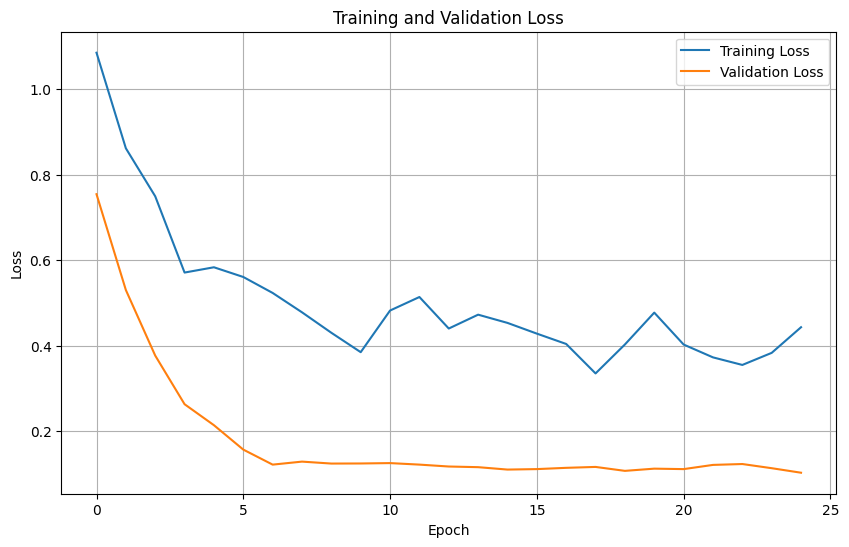

In [52]:
pretrained_model = models.resnet18(pretrained=True)

#exchange the last layer
num_ftrs = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_ftrs, 3)
pretrained_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(pretrained_model.parameters(),lr=0.001)

#scheduler
step_lr_scheduler = lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)

model_ft = train_model(pretrained_model,criterion,optimizer,step_lr_scheduler,num_epochs=25)

Epoch 0/24
----------
train Loss: 1.0481 Acc: 0.4524
val Loss: 0.9284 Acc: 0.5281

Epoch 1/24
----------
train Loss: 0.9206 Acc: 0.6032
val Loss: 0.7982 Acc: 0.6966

Epoch 2/24
----------
train Loss: 0.8530 Acc: 0.6984
val Loss: 0.6832 Acc: 0.7865

Epoch 3/24
----------
train Loss: 0.7866 Acc: 0.6667
val Loss: 0.5692 Acc: 0.9213

Epoch 4/24
----------
train Loss: 0.7889 Acc: 0.7222
val Loss: 0.5046 Acc: 0.9101

Epoch 5/24
----------
train Loss: 0.7075 Acc: 0.7698
val Loss: 0.4437 Acc: 0.9663

Epoch 6/24
----------
train Loss: 0.6433 Acc: 0.8016
val Loss: 0.3879 Acc: 0.9888

Epoch 7/24
----------
train Loss: 0.6504 Acc: 0.8095
val Loss: 0.4046 Acc: 0.9775

Epoch 8/24
----------
train Loss: 0.6455 Acc: 0.7857
val Loss: 0.3808 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.6016 Acc: 0.8413
val Loss: 0.3962 Acc: 0.9775

Epoch 10/24
----------
train Loss: 0.6779 Acc: 0.7698
val Loss: 0.3788 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.6563 Acc: 0.8016
val Loss: 0.3899 Acc: 0.9775

Ep

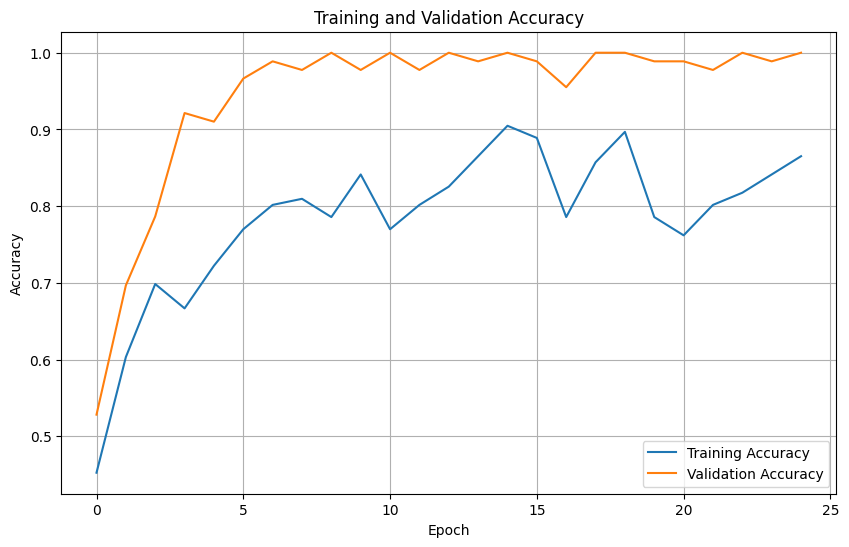

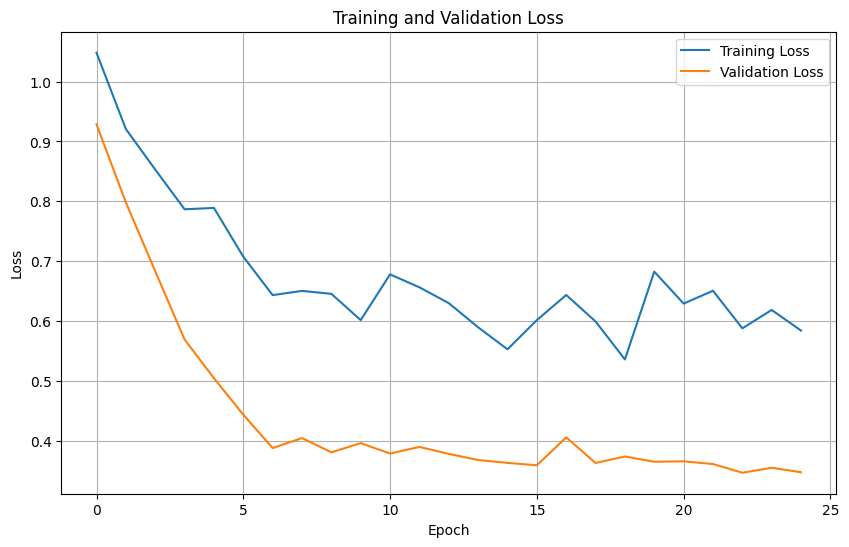

In [53]:
pretrained_model = models.resnet18(pretrained=True)
for param in pretrained_model.parameters():
    param.requires_grad = False

#exchange the last layer
num_ftrs = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_ftrs, 3)
pretrained_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(pretrained_model.parameters(),lr=0.001)

#scheduler
step_lr_scheduler = lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)

model_ft = train_model(pretrained_model,criterion,optimizer,step_lr_scheduler,num_epochs=25)